# Product Similarity Based Recomendations

### Hypothesis
EDA showed trends in products that were purchased together. We can help model this problem by creating features based on product data. For a MMVP we will focus on product categoris and price to create similarity features. We will know if we are right if the recommended (similar products) returned are in the `also bought` column of the data set.

### Approach
• All possible inputs, targets and types of models -> Criteria for first cut of the product

### Table of Contents
* Hypothesis
* Approach
* Table of Contents
* Set Up
* Modeling
* Tuning
* Results
* Insights
* Next Steps

### Setup
Create a spark session and specify the following variables for your enviornment. Notebook can be configured for local or cloud envoirnments. The following libraries are used for inital analysis and minimum modeling product.

In [2]:
# General 
import os
import csv
import re
import pandas as pd
import hashlib
from io import BytesIO
import pickle, gzip
import random as rand
import numpy as np
from pprint import pprint
from collections import defaultdict
from datetime import datetime

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLP 
import spacy
import nltk
from nltk.corpus import stopwords
import string
import gensim
from gensim.models import Phrases
from gensim.models import Word2Vec
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Data Vis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Save/Load Trained ML model
from sklearn.externals import joblib 
from datetime import datetime

# Spark 
from pyspark import SparkContext
from pyspark.sql import *
sc = SparkContext(master="local[3]")
sqlContext = SQLContext(sc)

### Env Variable Decloration

In [3]:
SOURCE_DIR='src/recommender'
WORKING_DIR = os.getcwd()
DATA_DIR = WORKING_DIR + '/../data'

S3_BUCKET = 'dse-cohort5-group1'
BUCKET_PREFIX = '/data-lake-standardization-zone'

DATA_S3URI = "s3://"+S3_BUCKET+BUCKET_PREFIX
AWS_REGION = 'us-east-1'

ROOT_DATA_DIR = '../data/'
DATA_DIR = ROOT_DATA_DIR+'data-lake-standardization-zone'

print("Your region: "+AWS_REGION)
print("Your s3 bucket: "+S3_BUCKET)
print("Your current working directory: "+WORKING_DIR)
print("Your training data location: " + DATA_S3URI)

Your region: us-east-1
Your s3 bucket: dse-cohort5-group1
Your current working directory: /Users/justin.shamoun/js/dse260-CapStone-Amazon/src/notebooks
Your training data location: s3://dse-cohort5-group1/data-lake-standardization-zone


### Local iteration example for product category data 

In [4]:
PATH = '/Users/justin.shamoun/js/dse260-CapStone-Amazon/src/data/data-lake-landing-zone/meta_Clothing_Shoes_and_Jewelry.json.gz'
categoryDict = defaultdict(list)
itemDict = defaultdict(list)
BATCH_SIZE = 100000

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

products = []
related = []
category = []

i = 0
for l in readGz(PATH):
    try:
        products.append([l['asin'], l['category'], l['also_buy']])
    except:
        continue
    if i > BATCH_SIZE:
        break
    i+=1
    
df = pd.DataFrame(products)
df.head()

,0,1,2
0,0206323190,"[Clothing, Shoes & Jewelry, Women, Shoes, Sand...","[B072LW94TG, B07BMBN792, B071DH8W2X, B01GF9AIO..."
1,0829750487,"[Clothing, Shoes & Jewelry, Men, Shoes]","[B00OGQ43GQ, 0829750479, 1433607964, 990049340..."
2,0871167042,"[Clothing, Shoes & Jewelry, Women, Jewelry]","[1627002332, 1634509374, 1627000763, 161243303..."
3,0982948530,"[Clothing, Shoes & Jewelry, Luggage & Travel G...","[0982948514, 1621642283]"
4,1519588135,"[Clothing, Shoes & Jewelry, Women, Clothing]","[1535298278, 1974248674, 1984152041, 099924253..."


### Category Preprocessing
All product categories are analyzied to compute product similarity. The categories are tokenize and cleaned using gensim’s simple_preprocess()

In [97]:
data = df[1].values.tolist()

def preproc(data):
    cdata = [re.sub('\S*@\S*\s?', '', sent) for sent in data] # Remove new line characters
    cdata = [re.sub('\s+', ' ', sent) for sent in cdata] # Remove distracting single quotes
    cdata = [re.sub("\'", "", sent) for sent in cdata]
    cdata = [s.replace('\\n', '') for s in cdata]
    cdata = [x.lower() for x in cdata]
    return cdata

dl = []
for x in data:
    d = preproc(x)
    dl.append(d)

In [98]:
def sent_to_words(sentences): 
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #␣ 􏰀→deacc=True removes punctuations
            
data_words = list(sent_to_words(dl))    
print(data_words[:1])

[['clothing', 'shoes', 'jewelry', 'women', 'shoes', 'sandals', 'flip', 'flops', 'synthetic', 'and', 'fabric', 'imported', 'heel', 'height', 'cm', 'platform', 'cm', 'material', 'eva', 'and', 'cloth', 'choose', 'the', 'usual', 'size', 'you', 'wear', 'if', 'you', 'like', 'loose', 'you', 'could', 'choos', 'one', 'size', 'plus', 'eva', 'rubber', 'sole', 'comfortable', 'handmade', 'special', 'occasion', 'sandals']]


### Lemmatization

In [99]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

['clothing shoe jewelry woman shoe sandal flip flop synthetic fabric import heel height cm platform cm material eva cloth choose usual size wear like loose could choos size eva rubber sole comfortable handmade special occasion sandal', 'clothing shoe jewelry man shoe']


In [100]:
vectorizer = CountVectorizer(analyzer='word',
                             min_df=10,
                             stop_words='english',
                             lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}')                         
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [101]:
# Check for sparsity
data_dense = data_vectorized.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.8347580841170589 %


### Bluid LDA Model

In [102]:
%%time
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

num_of_topic = 10
lda_model = LatentDirichletAllocation(n_components=num_of_topic, 
                                      max_iter=10,
                                      learning_method='online',
                                      random_state=100,
                                      batch_size=128,
                                      evaluate_every = -1,
                                      n_jobs = -1)


lda_output = lda_model.fit_transform(data_vectorized) 
print(lda_model)
print("Log Likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))
pprint(lda_model.get_params())

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Log Likelihood:  -1083488.9579876873
Perplexity:  165.74649598263773
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}
CPU times: user 8.42 s, sys: 2.82 s, total: 11.2 s
Wall time: 36.9 s


### GridSearch the best LDA model

In [103]:
%%time
n_topics = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
search_params = {'n_components': n_topics,
                 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation() # Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorized)

/Users/justin.shamoun/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 33min 52s, sys: 7.25 s, total: 34min
Wall time: 34min 5s


In [104]:
# Best Model
best_lda_model = model.best_estimator_ # Model Parameters
print("Best Model's Params: ", model.best_params_) # Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 13}
Best Log Likelihood Score:  -371840.8223572416
Model Perplexity:  142.45698094150592


## Save Trained Model 
Model can be saved and loaded for additonal training.

In [105]:
now = datetime.now() 
date_time = now.strftime("%m_%d_%Y_%H_%M")

# save the model to disk
model_file_path = date_time + "_model_lda.jablib"
joblib.dump(model, model_file_path)

# save best estimator after running Grid Search
with open(date_time+"_best_estimator_model.txt", "w") as text_file: 
    text_file.write(str(best_lda_model))

In [106]:
# load_model_file_path = '11_16_2019_21_13_model_lda.jablib'
# model = joblib.load(load_model_file_path)

## Analyze LDA Model Results

In [107]:
pd_cv_resut = pd.DataFrame.from_dict(model.cv_results_)
pd_cv_resut.head(2)

/Users/justin.shamoun/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/justin.shamoun/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/justin.shamoun/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,20.939634,0.919157,0.949416,0.067280,0.5,6,"{'learning_decay': 0.5, 'n_components': 6}",-367966.658154,-370199.495540,-387981.267316,-375381.573949,8954.893558,23,-739119.872702,-724970.165645,-702051.390655,-722047.143000,15273.640395
1,20.654716,1.073690,0.900087,0.053574,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-364544.576304,-376176.278053,-391819.804406,-377512.531265,11174.888424,28,-730686.994734,-731865.901547,-707552.940573,-723368.612285,11193.720236


In [108]:
pd_drop_cv_resut = pd_cv_resut.drop(['params'], axis=1)

## Visualize Model Results

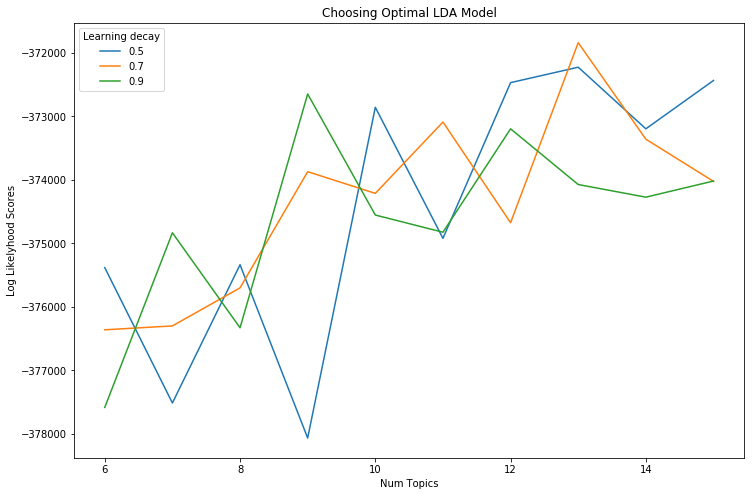

In [109]:
mean_test_score_5 = pd_drop_cv_resut. loc[pd_drop_cv_resut['param_learning_decay'] == 0.5]['mean_test_score']
mean_test_score_7 = pd_drop_cv_resut. loc[pd_drop_cv_resut['param_learning_decay'] == 0.7]['mean_test_score']
mean_test_score_9 = pd_drop_cv_resut. loc[pd_drop_cv_resut['param_learning_decay'] == 0.9]['mean_test_score']
log_likelyhoods_5 = mean_test_score_5.round().tolist()
log_likelyhoods_7 = mean_test_score_7.round().tolist()
log_likelyhoods_9 = mean_test_score_9.round().tolist()

plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [110]:
best_n_components = model.best_estimator_.get_params()['n_components']

### Dominent category topic for each product

In [111]:
lda_output = best_lda_model.transform(data_vectorized)

topicnames = ["Topic" + str(i) for i in range(best_n_components)]
docnames = ["Product" + str(i) for i in range(len(data))]
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black' 
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

df_document_topics = df_document_topic.head(15).style.applymap(color_green). applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,dominant_topic
Doc0,0,0,0,0.3,0,0,0.3,0,0,0,0,0.37,0,11
Doc1,0.01,0.85,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc2,0.01,0.85,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc3,0.01,0.36,0.01,0.01,0.01,0.01,0.01,0.01,0.54,0.01,0.01,0.01,0.01,8
Doc4,0.01,0.85,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc5,0.01,0.85,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1
Doc6,0.01,0.37,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.53,0.01,11
Doc7,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.42,0.47,0.01,11
Doc8,0.01,0.37,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.53,0.01,11
Doc9,0.01,0.2,0.01,0.01,0.01,0.01,0.01,0.01,0.74,0.01,0.01,0.01,0.01,8


### Top 10 documents related to each topic along with their topic proportions

In [112]:
for topic in topicnames: 
    print(df_document_topic[topic].sort_values(ascending=False).head(10).to_frame().T) 
    print('\n\n')

        Doc4525  Doc8180  Doc5578  Doc8220  Doc4529  Doc8222  Doc4396  \
Topic0     0.97     0.97     0.97     0.97     0.97     0.97     0.97   

        Doc9136  Doc4399  Doc5922  
Topic0     0.97     0.97     0.97  



        Doc13103  Doc7668  Doc9197  Doc5306  Doc3358  Doc1532  Doc654  Doc528  \
Topic1      0.93     0.92     0.92     0.92     0.92     0.92    0.92    0.92   

        Doc6434  Doc9198  
Topic1     0.92     0.92  



        Doc1072  Doc194  Doc5407  Doc3692  Doc5403  Doc5409  Doc9411  Doc69  \
Topic2     0.99    0.99     0.98     0.98     0.98     0.98     0.98   0.98   

        Doc491  Doc942  
Topic2    0.98    0.98  



        Doc11167  Doc12653  Doc10554  Doc904  Doc1782  Doc10257  Doc8714  \
Topic3      0.89      0.84      0.83    0.83     0.83      0.81     0.81   

        Doc3627  Doc3603  Doc6421  
Topic3     0.79     0.79     0.79  



        Doc7780  Doc11127  Doc5029  Doc6248  Doc12912  Doc10762  Doc6644  \
Topic4     0.97      0.97     0.96     0.9

### Topics distribution across products

In [113]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Products']
df_topic_distribution

,Topic Num,Num Documents
0,1,3299
1,10,1456
2,12,1359
3,0,1266
4,4,993
5,2,967
6,11,949
7,8,943
8,6,900
9,5,745


### Visualize the LDA model

In [114]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, 
                                 data_vectorized, 
                                 vectorizer,
                                 mds='tsne')

/Users/justin.shamoun/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Top 10 keywords for each topic 

In [115]:
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

In [116]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20): 
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []

    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs)) 
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])] 
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,clothing,shoe,jewelry,woman,lingerie,sock,sleep,bra,lounge,hosiery
Topic 1,shoe,clothing,jewelry,man,accessory,woman,costume,cap,hat,athletic
Topic 2,costume,accessory,shoe,jewelry,clothing,apparel,cosplay,include,size,measure
Topic 3,make,size,fit,cotton,design,inch,usa,great,style,quality
Topic 4,jewelry,shoe,watch,accessory,clothing,man,sunglass,wrist,woman,eyewear
Topic 5,clothing,shoe,jewelry,man,shirt,jean,sport,item,underwear,license
Topic 6,jewelry,shoe,woman,clothing,sandal,silver,necklace,earring,ring,platform
Topic 7,clothing,jewelry,shoe,polyester,man,jacket,coat,dress,wash,dry
Topic 8,cotton,clothing,shoe,jewelry,wash,polyester,machine,pocket,travel,import
Topic 9,watch,jewelry,case,steel,water,shoe,clothing,resistant,stainless,wrist


### Predicting topics for new text

In [117]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp): 
    global sent_to_words
    global lemmatization
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["most of people like apple"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

['make', 'size', 'fit', 'cotton', 'design', 'inch', 'usa', 'great', 'style', 'quality']
[[0.03846154 0.03846154 0.03846154 0.53846154 0.03846154 0.03846154
  0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
  0.03846154]]


### Clustering Products that share similar category topics

In [118]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model 
svd_model = TruncatedSVD(n_components=2) # 2 components 
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two␣ 􏰀→components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.05  0.98  0.07  0.04  0.04  0.03  0.05  0.03  0.04  0.02  0.07  0.09
   0.05]
 [ 0.16 -0.1   0.05  0.06  0.08  0.06  0.07  0.04  0.11  0.02  0.3   0.07
   0.91]]
Perc of Variance Explained: 
 [0.18 0.11]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

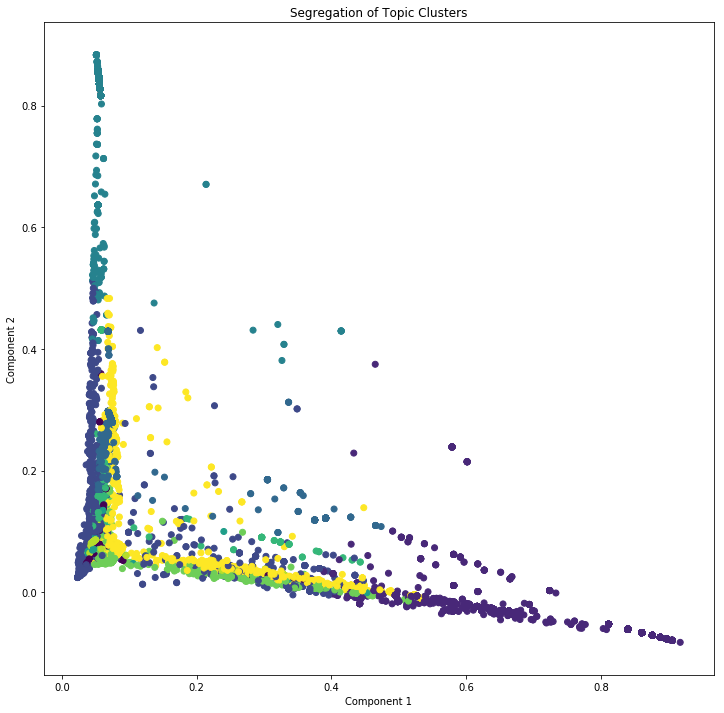

In [119]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters")

### Calculate product similarity for any text in category 


In [120]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=10, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]

    doc_ids = np.argsort(dists)[:top_n] 
    if verbose:
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


In [127]:
mytext = ["Womens dress shirt"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)

print('\n', doc_ids) 
print('\n', docs[0][:500])

Topic KeyWords:  ['shoe', 'leather', 'baby', 'sole', 'synthetic', 'approximately', 'measure', 'heel', 'clothing', 'jewelry']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.3 0.3 0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.  0.  0.  0.3 0.  0.  0.4 0.3 0. ]]

 [7174]

 ['Clothing, Shoes & Jewelry', 'Baby', 'Baby Boys', 'Clothing', 'Clothing Sets', 'Short Sets']
